[FX - multivariate quantiles and long horizon forecasting with N-HiTS](https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/nhits.html)
----



In [31]:
!pip install -r ./requirements.txt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Cloning https://github.com/KelvinKan/CP-Flow.git (to revision package-specific-version) to /private/var/folders/zb/tts3v_1n6_q7k08zvlx60d5m0000gn/T/pip-req-build-n7s0avva
  Running command git clone --filter=blob:none --quiet https://github.com/KelvinKan/CP-Flow.git /private/var/folders/zb/tts3v_1n6_q7k08zvlx60d5m0000gn/T/pip-req-build-n7s0avva
  Running command git checkout -b package-specific-version --track origin/package-specific-version
  Switched to a new branch 'package-specific-version'
  Branch 'package-specific-version' set up to track remote branch 'package-specific-version' from 'origin'.
  Resolved https://github.com/KelvinKan/CP-Flow.git to commit 02eb8f7243cafb8cf655dfd05c0ee32ccdd32248
  Preparing metadata (setup

In [32]:
import os
import warnings

warnings.filterwarnings("ignore")

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE, MQF2DistributionLoss

In [34]:
raw_data = pd.read_csv(
    "data/exchange_rate.csv", 
    names=["AUD/USD", "GMP/USD", "CAD/USD", "CHF/USD", "CHY/USD", "JPY/USD", "NZD/USD", "SGD/USD"]
)
raw_data.index = pd.date_range(start="1/1/1996", periods=len(raw_data), freq="D")
raw_data.tail()

,AUD/USD,GMP/USD,CAD/USD,CHF/USD,CHY/USD,JPY/USD,NZD/USD,SGD/USD
2016-10-05,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.690846,0.688565
2016-10-06,0.721839,1.223459,0.741155,0.977297,0.143763,0.008595,0.695701,0.690288
2016-10-07,0.723197,1.234111,0.745184,0.984446,0.143997,0.008562,0.695943,0.691419
2016-10-08,0.720825,1.233905,0.744131,0.980344,0.143993,0.008555,0.692689,0.690942
2016-10-09,0.720825,1.233905,0.744131,0.980344,0.143993,0.008555,0.692689,0.690942


In [35]:
d = []
for s in raw_data.columns:
    d.append({
        "pair": s,
        "value": raw_data[s],
        "date": raw_data.index,
        "time_idx": range(len(raw_data.index))
    })

data = pd.DataFrame(d).explode(['value', 'date', 'time_idx'])
data['time_idx'] = data['time_idx'].astype(int)
data['value'] = data['value'].astype(float)
data['series'] = data.index
data = data.reset_index(drop=True)

In [36]:
data

,pair,value,date,time_idx,series
0,AUD/USD,0.785500,1996-01-01,0,0
1,AUD/USD,0.781800,1996-01-02,1,0
2,AUD/USD,0.786700,1996-01-03,2,0
3,AUD/USD,0.786000,1996-01-04,3,0
4,AUD/USD,0.784900,1996-01-05,4,0
...,...,...,...,...,...
60699,SGD/USD,0.688565,2016-10-05,7583,7
60700,SGD/USD,0.690288,2016-10-06,7584,7
60701,SGD/USD,0.691419,2016-10-07,7585,7
60702,SGD/USD,0.690942,2016-10-08,7586,7


In [37]:
# data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
# # data["static"] = 2
# data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
# data.tail()

In [38]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

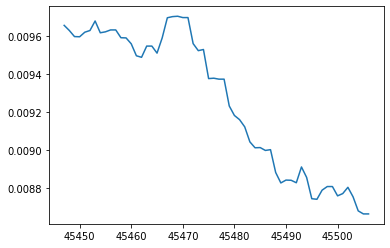

In [39]:
data.loc[data['pair']=='JPY/USD']['value'].iloc[-max_encoder_length+training_cutoff:training_cutoff].plot();

In [40]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.0192)

In [41]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=torch.cuda.device_count(), gradient_clip_val=1.0)
net = NHiTS.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
    backcast_loss_ratio=0.0,
    hidden_size=64,
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/jimako/ghq/github.com/tk42/nhits-trial/.lr_find_e2dcbb49-9ddb-4a0f-be96-77e245943169.ckpt


suggested learning rate: 0.251188643150958


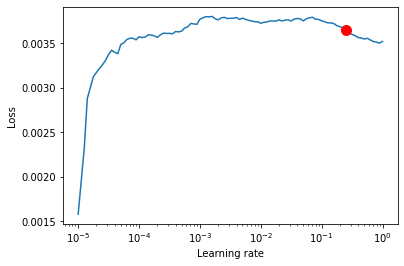

In [42]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [43]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=5,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
)


net = NHiTS.from_dataset(
    training,
    learning_rate=0.09,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type                 | Params
---------------------------------------------------------
0 | loss            | MQF2DistributionLoss | 5.1 K 
1 | logging_metrics | ModuleList           | 0     
2 | embeddings      | MultiEmbedding       | 0     
3 | model           | NHiTS                | 35.7 K
---------------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [44]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

In [45]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.0136)

In [46]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

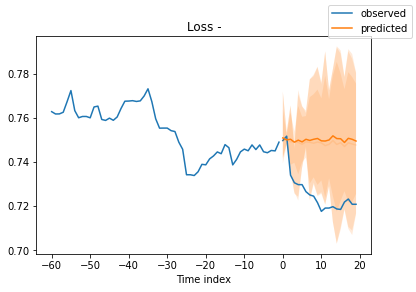

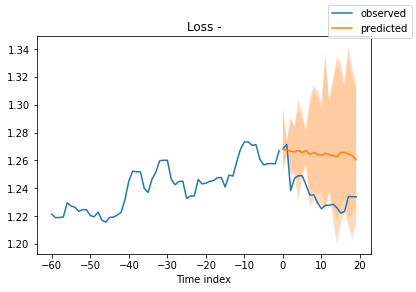

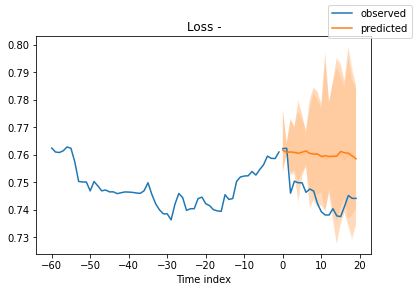

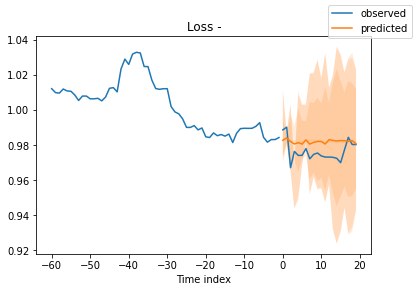

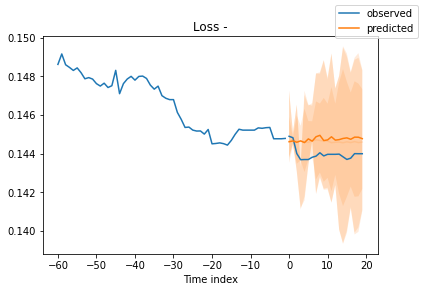

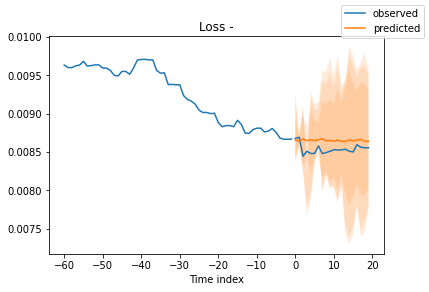

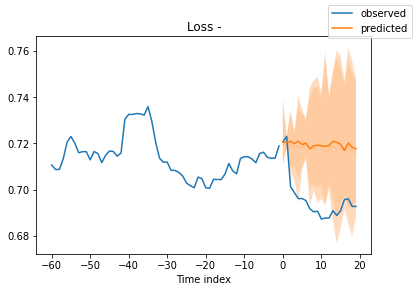

In [47]:
for idx in range(data.series.max()):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

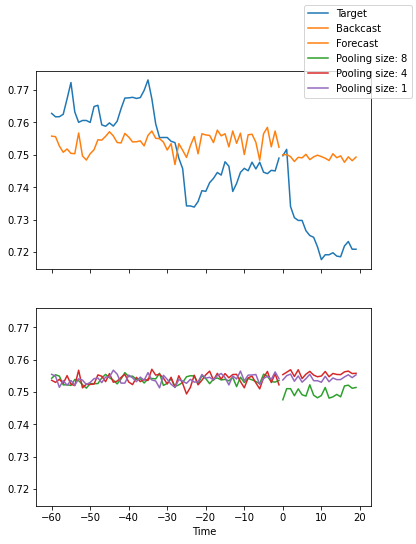

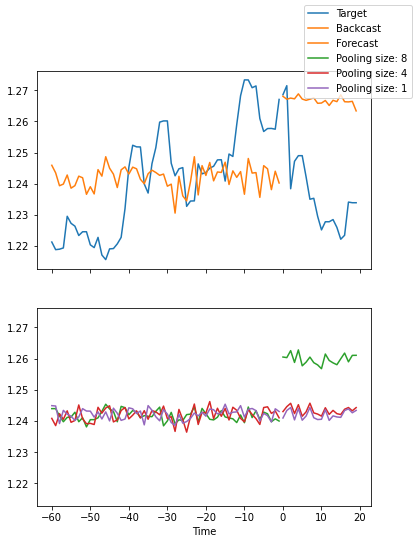

In [48]:
for idx in range(2):  # plot 10 examples
    best_model.plot_interpretation(x, raw_predictions, idx=idx);

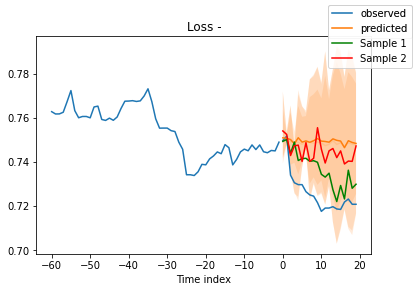

In [49]:
# sample 500 paths
samples = best_model.loss.sample(raw_predictions["prediction"][[0]], n_samples=500)[0]

# plot prediction
fig = best_model.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)
ax = fig.get_axes()[0]
# plot first two sampled paths
ax.plot(samples[:, 0], color="g", label="Sample 1")
ax.plot(samples[:, 1], color="r", label="Sample 2")
fig.legend();

In [50]:
print(f"Var(all samples) = {samples.var():.4f}")
print(f"Mean(Var(sample)) = {samples.var(0).mean():.4f}")

Var(all samples) = 0.0001
Mean(Var(sample)) = 0.0001


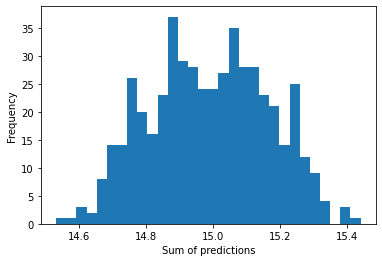

In [51]:
plt.hist(samples.sum(0).numpy(), bins=30)
plt.xlabel("Sum of predictions")
plt.ylabel("Frequency");